In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

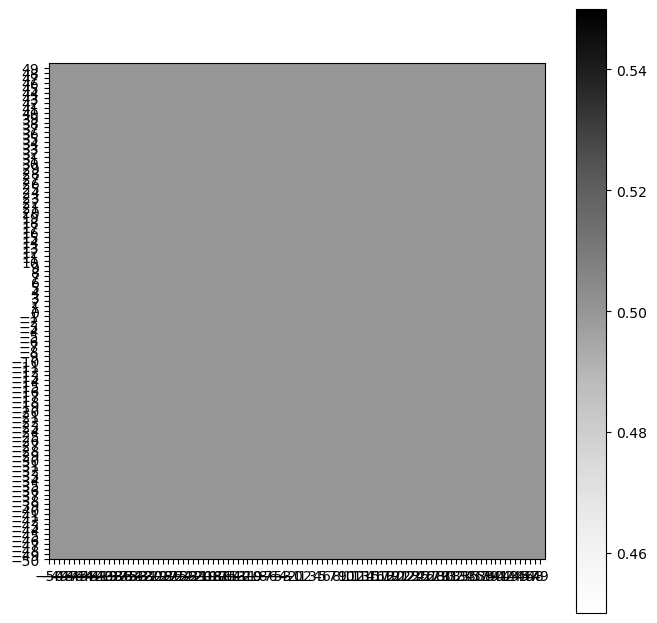

In [7]:
from skimage.draw import line

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

map_size = np.array([100, 100])
cell_size = 1

rows, cols = (map_size/cell_size).astype(int)

m = np.full((rows, cols), 0.5)

plt.imshow(m, cmap='Greys', origin='upper', extent=(-cols/2, cols/2, -rows/2, rows/2))

ax.set_xticks(np.arange(-(cols/2), cols/2, cell_size))
ax.set_yticks(np.arange(-(rows/2), rows/2, cell_size))

plt.colorbar()

line_bresenham = 0.5*np.ones((rows, cols), dtype=np.uint8)
occMap = 0.5*np.ones((rows, cols), dtype=np.uint8)

def bresenhams(robotPos, objectPos):
    xi, yi = np.floor((1/cell_size)*np.array([np.floor(10*robotPos[0]), np.floor(10*robotPos[1])])).astype(int)
    xoi, yoi = np.floor((1/cell_size)*np.array([objectPos[0], objectPos[1]])).astype(int)
    
    xi = np.floor(xi-rows/2).astype(int)
    yi = np.floor(yi-cols/2).astype(int)
    
    xoi = np.floor(xoi-rows/2).astype(int)
    yoi = np.floor(yoi-cols/2).astype(int)
    occMap[yoi][xoi] = 1
    
    rr, cc = line(yi, xi, yoi, xoi)
    line_bresenham[rr, cc] = 1
    for j in range(len(rr)):
        if(occMap[rr[j]][cc[j]] != 1):
            occMap[rr[j]][cc[j]] = 0

In [8]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

def readSensorData(clientId=-1, 
                    range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    returnCodeRanges, string_range_data = sim.simxGetStringSignal(clientId, range_data_signal_id, sim.simx_opmode_streaming)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    returnCodeAngles, string_angle_data = sim.simxGetStringSignal(clientId, angle_data_signal_id, sim.simx_opmode_blocking)

    # check the if both data were obtained correctly
    if returnCodeRanges == 0 and returnCodeAngles == 0:
        # unpack data from range and sensor messages
        raw_range_data = sim.simxUnpackFloats(string_range_data)
        raw_angle_data = sim.simxUnpackFloats(string_angle_data)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None

def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

def occGrid(q, hokuyo, laser_data, max_sensor_range=5):
    
    # Transform laser readings from local to global
    rotationWL = Rz(hokuyo[3])
    translationWL = [hokuyo[0], hokuyo[1], hokuyo[2]]
    transformWL = np.column_stack((rotationWL, translationWL))
    aux = np.array([0, 0, 0, 1])
    transformWL = np.row_stack((transformWL, aux))
    
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            
            xg = np.floor(10*x/cell_size)-2
            yg = np.floor(10*y/cell_size)-2
            
            T = transformWL @ np.array([xg, yg, 0, 1])
                
            bresenhams(q[0:2], T[0:2])
            
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    plt.imshow(occMap, cmap='Greys', extent=(0, cols, rows, 0))

    ax.set_xticks(np.arange(0, cols, cell_size))
    ax.set_yticks(np.arange(0, rows, cell_size))

    plt.colorbar()
    plt.show()

    # Return map with new probabilities 



Program started
Connected to remote API server


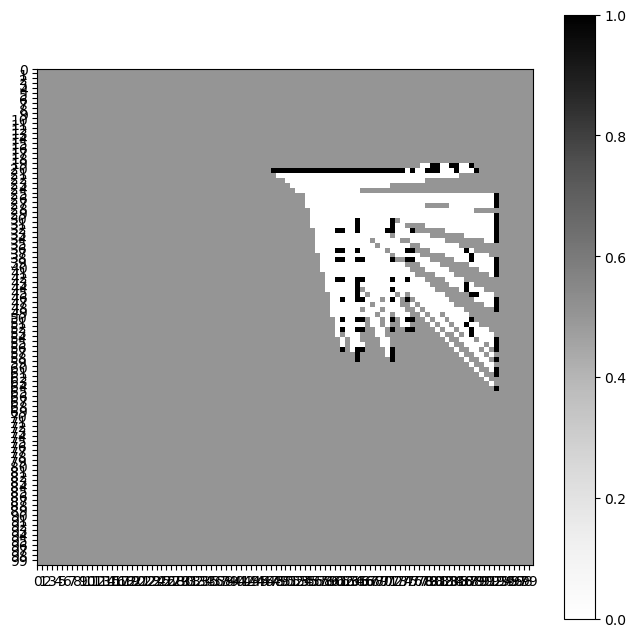

Program ended


In [9]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    robotName = 'kobuki'
    hokuyoName = 'fastHokuyo'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotName, sim.simx_opmode_oneshot_wait)
    returnCode, hokuyoHandle = sim.simxGetObjectHandle(clientID, hokuyoName, sim.simx_opmode_oneshot_wait)
    
#     returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotName + '_leftMotor', sim.simx_opmode_oneshot_wait)
#     returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotName + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    returnCode, robotPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    
    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    returnCode = 1
    while returnCode != 0:
        returnCode, range_data = sim.simxGetStringSignal(clientID, laser_range_data, sim.simx_opmode_streaming + 10)

    raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T

    L = 0.230
    r = 0.035
    t = 0
    rho = np.inf
    while t < 1:
        
        returnCode, robotPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        returnCode, robotOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])
    
        returnCode, hokuyoPos = sim.simxGetObjectPosition(clientID, hokuyoHandle, -1, sim.simx_opmode_oneshot_wait)
        returnCode, hokuyoOri = sim.simxGetObjectOrientation(clientID, hokuyoHandle, -1, sim.simx_opmode_oneshot_wait)
        hokuyoConfig = np.array([hokuyoPos[0], hokuyoPos[1], hokuyoPos[2], hokuyoOri[2]])
        
        raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
        laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        # Occupancy Grid calcs
        occGrid(robotConfig, hokuyoConfig, laser_data)
        
        # Time to run simulation just for test
        t += 1
                     
        
#         sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, vr, sim.simx_opmode_oneshot_wait)
#         sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, vl, sim.simx_opmode_oneshot_wait)

#     sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
#     sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')